In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/content/generator_bidding_cleaned-2.csv")
df['INTERVAL_DATETIME'] = pd.to_datetime(df['INTERVAL_DATETIME'])
df['HOUR'] = df['INTERVAL_DATETIME'].dt.hour

df.head()


,INTERVAL_DATETIME,DUID,Region,Generation Type,MARGINAL_VOLUME,band_num,PRICE,HOUR
0,2025-04-01 04:05:00,ALDGASF1,QLD1,Solar,387.0,2,-194.22,4
1,2025-04-01 04:05:00,AVLSF1,NSW1,Solar,190.0,1,-844.60,4
2,2025-04-01 04:05:00,BANN1,VIC1,Solar,88.0,1,-839.34,4
3,2025-04-01 04:05:00,BARKIPS1,SA1,OCGT,100.0,7,561.04,4
4,2025-04-01 04:05:00,BARKIPS1,SA1,OCGT,110.0,10,17501.75,4


<ipython-input-7-a98dafafb56b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Price_Bin'] = pd.cut(df_filtered['PRICE'], bins=price_bins, labels=labels)
<ipython-input-7-a98dafafb56b>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_filtered.groupby(['Tech_Group', 'Price_Bin'])['MARGINAL_VOLUME'].sum().reset_index()


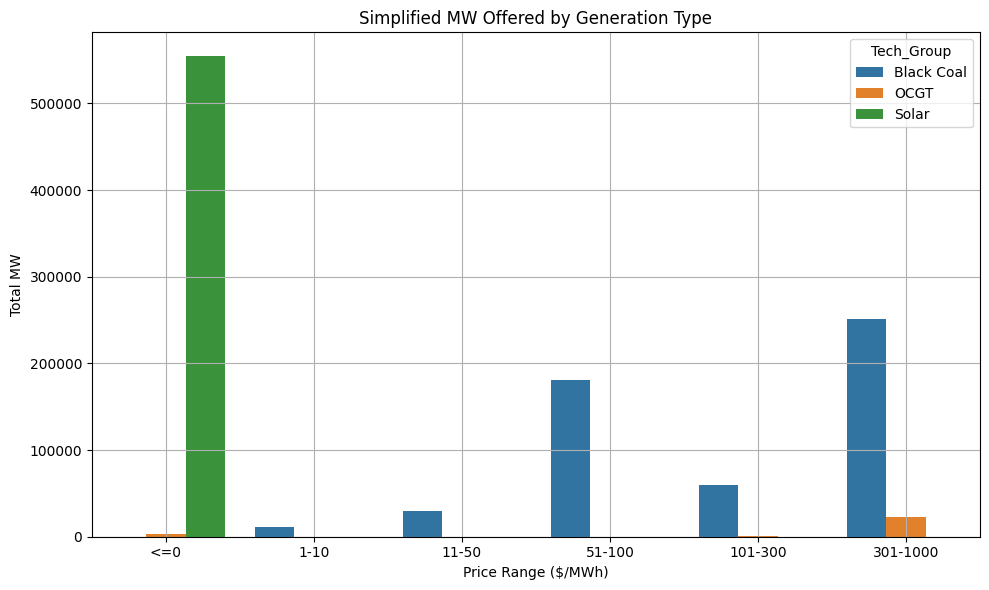

In [7]:
# Filter to typical price range
df_filtered = df[(df['PRICE'] >= -100) & (df['PRICE'] <= 1000)]

# Define bins and labels
price_bins = [-100, 0, 10, 50, 100, 300, 1000]
labels = ['<=0', '1-10', '11-50', '51-100', '101-300', '301-1000']

# Assign bins
df_filtered['Price_Bin'] = pd.cut(df_filtered['PRICE'], bins=price_bins, labels=labels)

# Rename 'Generation Type' to 'Tech_Group' for consistency with your code
df_filtered = df_filtered.rename(columns={'Generation Type': 'Tech_Group'})

# Group and summarize marginal volumes
summary = df_filtered.groupby(['Tech_Group', 'Price_Bin'])['MARGINAL_VOLUME'].sum().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the simplified bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=summary, x='Price_Bin', y='MARGINAL_VOLUME', hue='Tech_Group')
plt.title("Simplified MW Offered by Generation Type")
plt.xlabel("Price Range ($/MWh)")
plt.ylabel("Total MW")
plt.tight_layout()
plt.grid(True)
plt.show()


Key Insights from the Chart


Solar (Green Bars)



Almost all solar energy is bid at $0 or below, offering over 550,000 MW in the <= 0 price range.
This confirms a common strategy: solar generators bid very low to ensure their electricity is used.
This makes sense because solar energy is low-cost and cannot be stored easily, so it's better to be dispatched even at low or negative prices.


Black Coal (Blue Bars)



Black coal generators distribute their bids across a wide range of prices:
Small volume in low prices (1–10 and 11–50).
Large volumes in mid to high ranges (51–100, 101–300, 301–1000).
This suggests a strategic approach, possibly adjusting to market demand:
Bid low to get guaranteed dispatch when needed.
Bid high during peak demand to maximize revenue.
Black coal is used as baseload generation, but its bidding reflects flexibility in market positioning.


OCGT (Orange Bars)



OCGT (gas-fired peaking generators) appear only in the highest price bracket (301–1000).
These are expensive generators used only when demand is high and prices justify the cost.
This confirms their role as backup or emergency power sources.


Conclusion Summary



Solar bids almost exclusively at free or negative prices, aiming for constant dispatch.
Black Coal shows diversified pricing, reflecting both cost coverage and profit opportunities.
OCGT only participates when prices are high, matching their use as high-cost, fast-response units.
This chart provides a clear, intuitive comparison of how different generation types position themselves in the market based on their operational costs and roles in the electricity system.

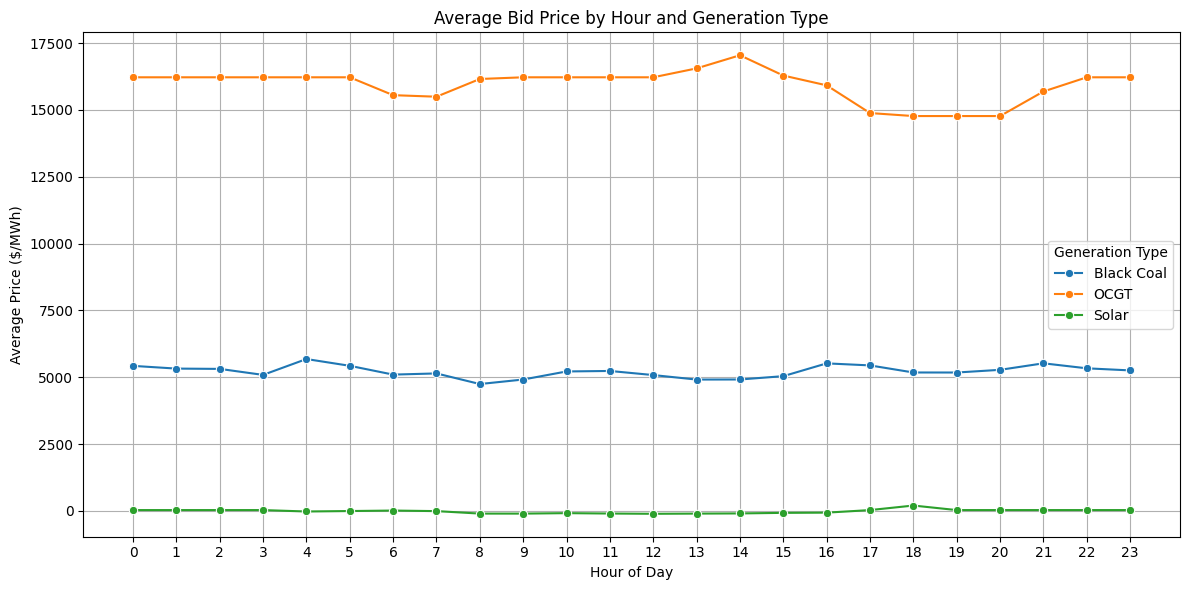

In [8]:
# Calculate average bid price by generation type and hour of day
df['INTERVAL_DATETIME'] = pd.to_datetime(df['INTERVAL_DATETIME'])
df['HOUR'] = df['INTERVAL_DATETIME'].dt.hour

avg_price_by_hour = df.groupby(['Generation Type', 'HOUR'])['PRICE'].mean().reset_index()

# Plot the time-of-day bid price trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_price_by_hour, x='HOUR', y='PRICE', hue='Generation Type', marker='o')
plt.title("Average Bid Price by Hour and Generation Type")
plt.xlabel("Hour of Day")
plt.ylabel("Average Price ($/MWh)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


Hourly Bidding Behaviour – Key Insights

 Solar (Pink Line)

Bids are consistently negative or near $0, especially between 8 AM to 6 PM, when solar production is active.
This reflects solar’s strategy to always get dispatched when sunlight is available, regardless of market price.
No significant change across the day because solar has no fuel cost, only availability based on sunlight.


Black Coal (Orange Line)



Average bids from black coal remain stable throughout the day, mostly in the range of $4800 to $5600/MWh.
This suggests a steady pricing strategy, likely because black coal is used for baseload generation, supplying consistent power regardless of demand spikes.
Small peaks occur around 4 AM and 4 PM–6 PM, possibly reflecting increased demand during early morning and evening transition periods.


OCGT (Red Line)



OCGT prices are consistently the highest, averaging around $16,000–17,000/MWh.
Slight dip during midday (hours 6–12), then a spike in the evening (around 2 PM to 8 PM).
This confirms that OCGT is mainly used during high-demand periods, especially in the afternoon and evening peaks.
Their high prices reflect their role as peaking generators, which are costly but quick to dispatch.


Conclusion Summary



Solar bids are flat and low during daylight hours — aimed at maximizing dispatch.
Black coal maintains moderate, stable pricing — ensuring reliable base power.
OCGT bids very high and are timed to match peak demand hours — maximizing profits when demand spikes.
This chart clearly shows that bidding strategies are tied closely to the time of day and each generation type's operational characteristics.

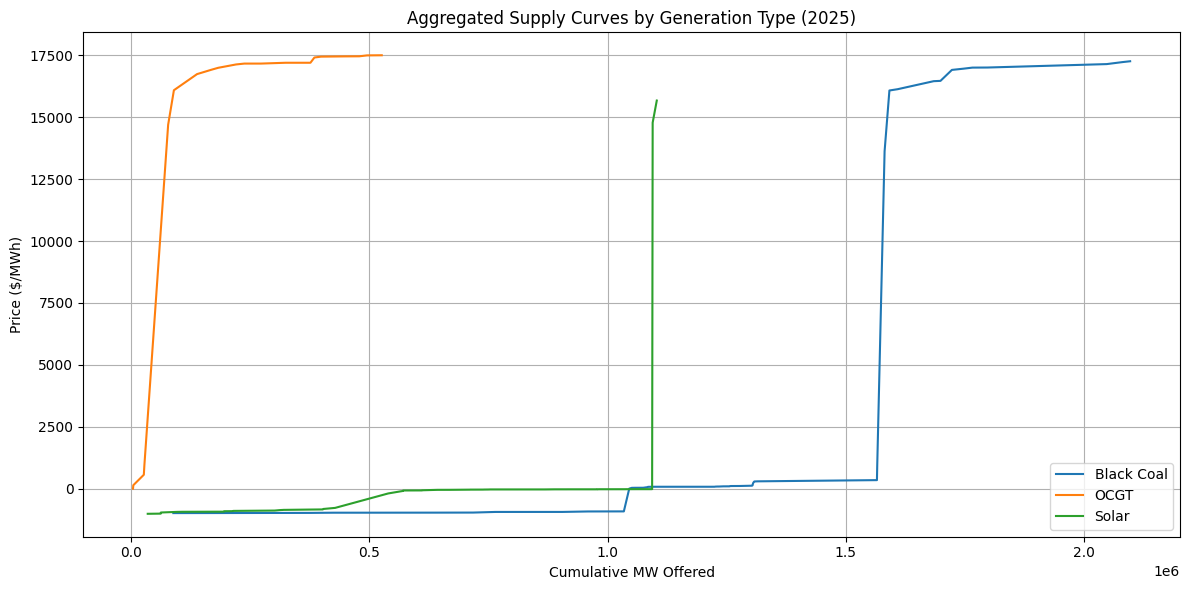

In [9]:
# Group by generation type and price, then sum MW to get total supply at each price point
agg_supply = df.groupby(['Generation Type', 'PRICE'])['MARGINAL_VOLUME'].sum().reset_index()

# Sort by generation type and price
agg_supply = agg_supply.sort_values(['Generation Type', 'PRICE'])

# Compute cumulative volume for supply curve
agg_supply['CUMULATIVE_VOLUME'] = agg_supply.groupby('Generation Type')['MARGINAL_VOLUME'].cumsum()

# Plot aggregated supply curves
plt.figure(figsize=(12, 6))
for gen_type, group in agg_supply.groupby('Generation Type'):
    plt.plot(group['CUMULATIVE_VOLUME'], group['PRICE'], label=gen_type)

plt.title("Aggregated Supply Curves by Generation Type (2025)")
plt.xlabel("Cumulative MW Offered")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


solar:


Cheapest and ConsistentThe solar curve is flat and horizontal, staying entirely in the negative or near-zero price range.This tells us:Solar generators are not aiming to make money per MWh.Their priority is to get dispatched, possibly because they have no fuel cost and rely on availability (sunlight).Their bids remain cheap regardless of how much they offer, showing a uniform pricing strategy.



 OCGT:


 Scarce and ExpensiveThe OCGT curve is very steep, rising to $17,500/MWh almost instantly.What this means:OCGT (gas turbines) offer very small volumes of power.But when they do, they bid at extremely high prices %E2%80%94 only to be used during critical demand peaks.This confirms their role as peaking or emergency generators.


 Black Coal:


 Tiered and DominantBlack Coal has the widest supply range on the x-axis (i.e., offers the most electricity).The curve starts low and gradually climbs, showing a tiered pricing strategy:Some bids are very cheap, likely to ensure dispatch during low demand.Others are higher, likely to profit during peak periods.This indicates that black coal generators are flexible and strategic, adjusting prices across different blocks of generation.



 Final Interpretation


 Solar = cheap, consistent bids maximize use of available sunlight.


 OCGT = rare, very high bids only step in when prices skyrocket.


 Black Coal = large, tiered bids adapts to market conditions to stay competitive and profitable.

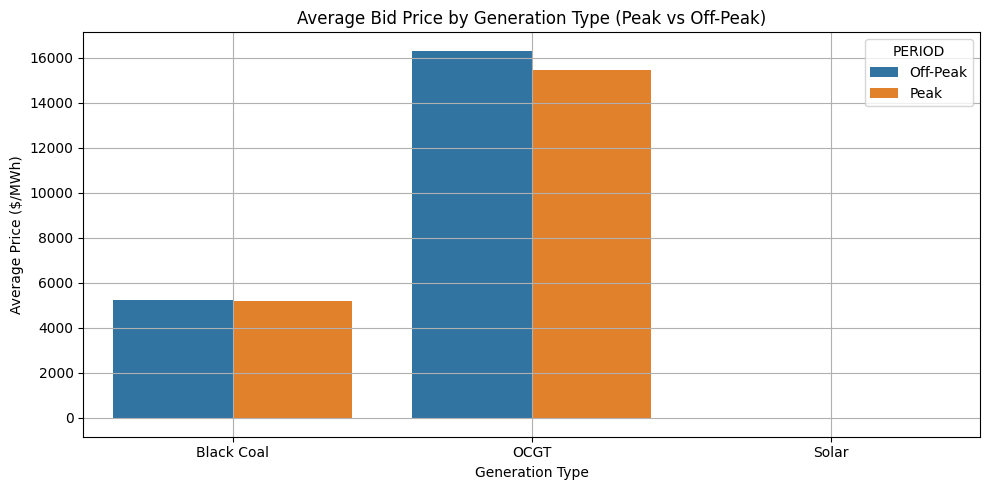

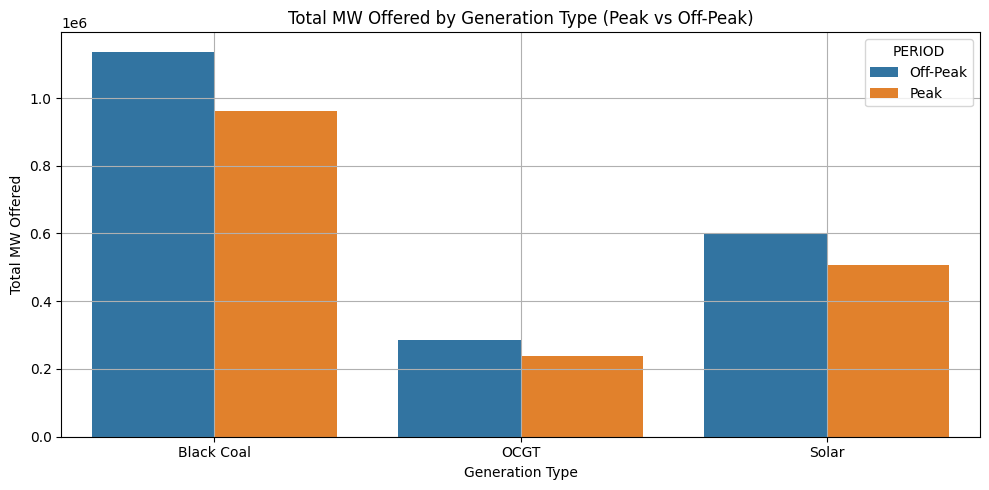

In [10]:

# Define peak hours: 6–10 AM and 4–9 PM
peak_hours = list(range(6, 11)) + list(range(16, 22))
df['PERIOD'] = df['HOUR'].apply(lambda h: 'Peak' if h in peak_hours else 'Off-Peak')

# Summarize by generation type and period
summary_peak_offpeak = df.groupby(['Generation Type', 'PERIOD']).agg(
    avg_price=('PRICE', 'mean'),
    total_mw=('MARGINAL_VOLUME', 'sum'),
    bid_count=('DUID', 'count')
).reset_index()

# Plot average price by generation type and period
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_peak_offpeak, x='Generation Type', y='avg_price', hue='PERIOD')
plt.title("Average Bid Price by Generation Type (Peak vs Off-Peak)")
plt.ylabel("Average Price ($/MWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot total MW offered by generation type and period
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_peak_offpeak, x='Generation Type', y='total_mw', hue='PERIOD')
plt.title("Total MW Offered by Generation Type (Peak vs Off-Peak)")
plt.ylabel("Total MW Offered")
plt.grid(True)
plt.tight_layout()
plt.show()